In [65]:
%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

import pandas as pd
import json
import missingno as msno

In [66]:
from glob import glob

In [67]:
paths = [el for el in glob('./data/*.csv') if 'EF_battles' not in el]
paths

['./data/Western Front.csv',
 './data/Atlantic Ocean.csv',
 './data/Mediterranean Front.csv',
 './data/China Front.csv',
 './data/Eastern Front.csv',
 './data/Southeast Asia Front.csv',
 './data/African Front.csv',
 './data/Indian Ocean.csv',
 './data/Pacific Theatre.csv']

In [68]:
datas = pd.concat([pd.read_csv(path) for path in paths], sort=False).reset_index(drop=False)

In [69]:
datas.shape

(624, 26)

In [70]:
datas.level.value_counts()

100    510
1       71
3       33
5        9
7        1
Name: level, dtype: int64

In [71]:
battles = datas[datas.level == 100]

In [72]:
columns = ['Location', 'name', 'Date', 'Result', 'Belligerents.allies',
           'Belligerents.axis', 'Casualties and losses.allies', 'Casualties and losses.axis']

In [74]:
battles.loc[battles.Location.isnull(), columns].tail()

,Location,name,Date,Result,Belligerents.allies,Belligerents.axis,Casualties and losses.allies,Casualties and losses.axis
420,NaN,Battle of Oktwin,NaN,NaN,NaN,NaN,NaN,NaN
427,NaN,Chindits Raid,NaN,NaN,NaN,NaN,NaN,NaN
445,NaN,Operation Matterhorn,NaN,NaN,United States,Japan,NaN,NaN
509,NaN,Action of 8 May 1941,NaN,NaN,United Kingdom,Germany,1 killed 1 heavy cruiser slightly damaged,332 killed 60 captured 1 auxiliary cruiser sunk
510,NaN,Japanese occupation of the Andaman Islands,NaN,NaN,NaN,NaN,NaN,NaN


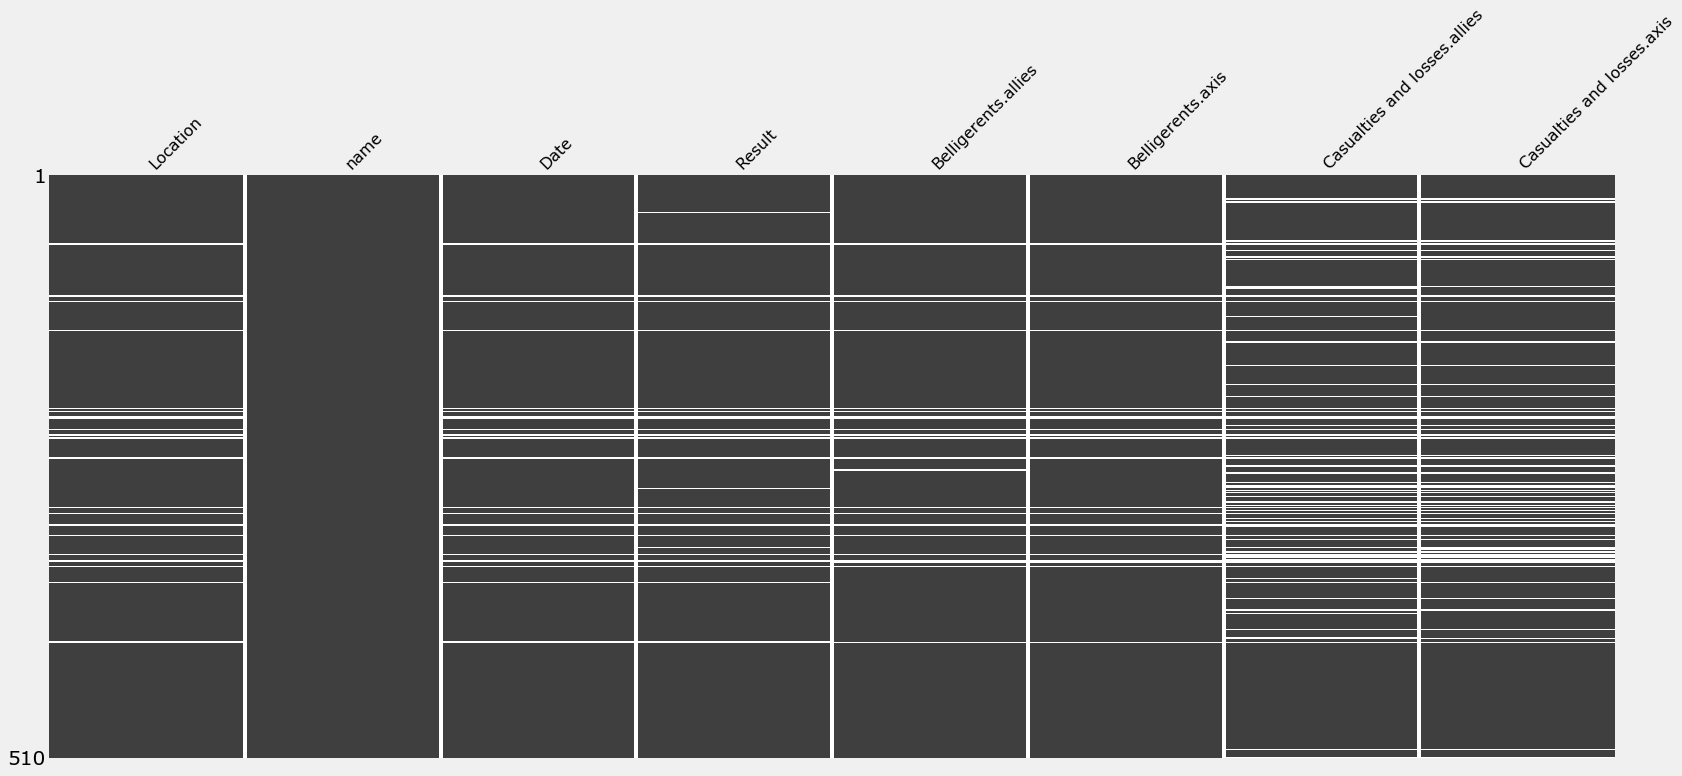

In [75]:
msno.matrix(battles[columns], labels=True, sparkline=False)

In [76]:
mask = battles[['Date', 'Location']].isnull().all(1)

In [77]:
battles=battles.dropna(subset=['Date', 'Location'])

# Location

In [111]:
pattern = r'/ ([\d|\.|-]+); ([\d|\.|-]+)'

In [112]:
# battles.iloc[9]['Location']

In [113]:
battles[['Lattitude', 'Longitude']] = battles.Location.str.extract(pattern)

In [114]:
for col in  'Lattitude', 'Longitude':
    battles[col] =  battles[col].astype(float)

In [115]:
f"{(battles['Lattitude'].isnull().sum() / len(battles)):.1%}"

'68.7%'

# Geocode

So, we actually don't have coordinates for 78% of our battles, which is too hight. As an alternative, let's use the geocoding function we wrote in chapter 6! Of course, some addesses are obsolete, but most will, probably, get us to the coordinates

In [136]:
from geocode import nominatim_geocode # copied the file from folder "Chapter06"

In [137]:
from tqdm import tqdm, tqdm_notebook
tqdm().pandas()



0it [00:00, ?it/s]

In [138]:
geo_mask = battles['Lattitude'].isnull()

In [140]:
battles.loc[geo_mask, 'Location'].sample(15, random_state=2019)

257                             Bryansk, Soviet Union
330                                            Poland
280     Rzhev and Velikie Luki salients, Russian SFSR
230                                  Petsamo, Finland
115                                    Wesel, Germany
490                                              Iraq
8                               Mill, the Netherlands
397                                            Malaya
593              New Georgia Islands, Solomon Islands
358                   Debrecen / Nyíregyháza, Hungary
581           Huon Peninsula, Territory of New Guinea
562                      Guadalcanal, Solomon Islands
494    off Casablanca, French Morocco, Atlantic Ocean
240           Petsamo, Litsa River, Rybachy Peninsula
234                                  Petsamo, Finland
Name: Location, dtype: object

In [141]:
location = battles['Location'].str.lower().str.replace('near ', '')

In [142]:
replacements = {
    'Ukrainian SSR, Soviet Union': 'Ukraine',
    'Russian SFSR, Soviet Union': 'Russia',
    'Russian SFSR': 'Russia',
    'Belorussian SSR': 'Belorus',
    'Soviet Union': '',
    'USSR': '',
    ', Poland (now Ukraine)': 'Ukraine',
    'east prussia (now kaliningrad oblast)': 'Kaliningrad Oblast, Russia',
    ', czechoslovakia': ', czech republic',
    'königsberg, germany (now: kaliningrad, russia)': 'Kaliningrad Oblast, Russia',
    'lwów, lwów voivodeship, poland': 'Lvov, Ukraine',
    'leningrad region, ; narva, estonia': 'Narva, Estonia',
    'Kingdom of Hungary': 'Hungary',
    'odessa region, ukraine': 'Odessa, Ukraine'
}

In [143]:
for k, v in replacements.items():
    location = location.str.replace(k.lower(), v.lower(), regex=False)

In [144]:
def vectorized_geocode(x):
    result = nominatim_geocode(x)
    if len(result) == 0:
        return dict()
    return {k:result[0][k] for k in ('lat', 'lon', 'importance', 'display_name')}

In [145]:
# nominatim_geocode('realm commissariat ostland\ngeneral district of latvia\nkreisgebiete liepaja\nkreise aizpute\nkreise kuldiga\nkreise liepaja\nkreise liepaja (city)\nkreise talsi\nkreise ventspils\nkreisgebiete jelgava\nkreise jelgava\nkreise tukums\ngeneral district of lithuania\nkreisgebiete siauliai\nkreise kretinga\nkreise mazeikiai'.replace('\n', ' '))

In [146]:
location[location.fillna('').str.contains('kreisgebiete')] = 'Courland Peninsula'

In [147]:
location[geo_mask]

1                                                denmark
2                                         narvik, norway
3                                   drøbak sound, norway
4             dombås area in dovre, gudbrandsdal, norway
5      åndalsnes and points to the north and east, no...
8                                  mill, the netherlands
11     maastricht, netherlands, and the surrounding area
12                             dutch province of zeeland
21                                            luxembourg
29                                         france, paris
30                                       dunkirk, france
33                                 franco-italian border
35                           england and english channel
36                  southern england and english channel
37                   london, england and english channel
44                                        dieppe, france
45                                  berlin, nazi germany
47                             

In [148]:
response = location[geo_mask].str.replace('\n', ' ').progress_apply(vectorized_geocode)



  0%|          | 0/332 [00:00<?, ?it/s]

  7%|▋         | 24/332 [00:01<00:19, 15.87it/s]

  8%|▊         | 25/332 [00:03<02:33,  1.99it/s]

  8%|▊         | 26/332 [00:04<04:05,  1.25it/s]

  8%|▊         | 27/332 [00:06<05:10,  1.02s/it]

  8%|▊         | 28/332 [00:07<05:52,  1.16s/it]

  9%|▊         | 29/332 [00:09<06:22,  1.26s/it]

  9%|▉         | 30/332 [00:10<06:43,  1.34s/it]

  9%|▉         | 31/332 [00:12<06:56,  1.38s/it]

 10%|▉         | 32/332 [00:13<07:03,  1.41s/it]

 10%|▉         | 33/332 [00:15<07:10,  1.44s/it]

 10%|█         | 34/332 [00:17<08:47,  1.77s/it]

 11%|█         | 35/332 [00:19<08:39,  1.75s/it]

 11%|█         | 36/332 [00:20<08:18,  1.68s/it]

 11%|█         | 37/332 [00:22<08:01,  1.63s/it]

 11%|█▏        | 38/332 [00:23<07:50,  1.60s/it]

 12%|█▏        | 39/332 [00:25<07:39,  1.57s/it]

 12%|█▏        | 40/332 [00:27<08:19,  1.71s/it]

 12%|█▏        | 41/332 [00:28<08:00,  1.65s/it]

 13%|█▎        | 42/332 [00:30<07:45,  1.60s/it]

 13%|█▎

In [149]:
response.iloc[0]

{'lat': '55.670249',
 'lon': '10.3333283',
 'importance': 0.932215312866484,
 'display_name': 'Denmark'}

In [150]:
battles.loc[geo_mask, 'Location'].iloc[0]

'Denmark'

In [151]:
geo_df = pd.DataFrame(response.tolist(), index = response.index)
geo_df.rename(columns={'lat': 'Lattitude', 'lon': ' Longitude'}, inplace=True)

In [152]:
rmask = geo_df['importance'].isnull()  # still no location

In [153]:
f'{rmask.sum() / len(battles):.1%}'

'30.0%'

In [154]:
location[geo_mask].loc[rmask]

3                                   drøbak sound, norway
4             dombås area in dovre, gudbrandsdal, norway
5      åndalsnes and points to the north and east, no...
11     maastricht, netherlands, and the surrounding area
33                                 franco-italian border
36                  southern england and english channel
37                   london, england and english channel
45                                  berlin, nazi germany
56     verrières ridge, 8 km (5.0 mi) south of caen, ...
57     verrières ridge (8 km (5 miles) south of caen)...
67                     mont ormel, northeast of chambois
71                           paris and outskirts, france
76              off la ciotat, france, mediterranean sea
78     along and around the siegfried line, (france, ...
94                      rur valley and environs, germany
105                  belgium, the netherlands and france
107    alsace and lorraine, france and rhineland-pala...
109        limburg (netherlands

## Time

In [155]:
# pd.to_datetime('September 1939')

In [156]:
battles.loc[94, 'Date']

'16 November\xa0– 16 December 1944'

In [157]:
d = ('January', 'February', 'March', 'April', 'May', 
     'June', "July",' August', 'September', 'October', 'November', 'December')

month_pattern = r'(' + "|".join(d) + ')'

In [158]:
year_pattern = r'(19\d\d)'

In [159]:
year_extracted = battles['Date'].str.extractall(year_pattern).unstack()

In [160]:
# len(d.iloc[:, -1].notnull())
year_extracted[year_extracted.iloc[:, -1].notnull()]

0                  
match     0     1     2     3
40     1940  1941  1940  1941
107    1944  1945  1944  1945
193    1943  1943  1943  1943
299    1943  1943  1943  1943
538    1942  1943  1942  1943
556    1942  1942  1942  1942
585    1944  1944  1944  1944

In [161]:
# d[d.iloc[:, -1].notnull()]

In [162]:
battles.loc[94, 'Date']

'16 November\xa0– 16 December 1944'

In [163]:
year_extracted = year_extracted.iloc[:, :2]

In [164]:
year_extracted.head(10)

0      
match     0     1
0      1939  1939
1      1940   NaN
2      1940   NaN
3      1940   NaN
4      1940   NaN
5      1940   NaN
8      1940   NaN
9      1940   NaN
10     1940   NaN
11     1940   NaN

In [165]:
year_extracted.iloc[:, 1] = year_extracted.iloc[:, 1].fillna(year_extracted.iloc[:, 0])

In [166]:
month_extracted = battles['Date'].str.extractall(month_pattern).unstack()

In [167]:
for i in range(2, month_extracted.shape[1]+1):
    month_extracted.iloc[:, -1].fillna(month_extracted.iloc[:, -i], inplace=True)

In [168]:
month_extracted = month_extracted.iloc[:, [0, -1]]

In [169]:
year_extracted.columns = month_extracted.columns = ['start', 'end']
I = battles.index
cols = 'start', 'end'

for col in cols:
    battles[col] = pd.to_datetime(month_extracted.loc[I, col] + ' ' + year_extracted.loc[I, col])

/Users/philippk/anaconda3/envs/packt/lib/python3.7/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


# Sides Swap

In [170]:
words = ['Germany', 'Italy', 'Estonian conscripts']

In [171]:
for word in words:
    mask = battles['Belligerents.allies'].fillna('').str.contains(word)
    axis_party = battles.loc[mask, ['Belligerents.allies', 'Casualties and losses.allies']].copy()
    battles.loc[mask, ['Belligerents.allies', 'Casualties and losses.allies']] = battles.loc[mask, ['Belligerents.axis', 'Casualties and losses.axis']].values
    battles.loc[mask, ['Belligerents.axis', 'Casualties and losses.axis']] = axis_party.values

## Casualties

In [172]:
battles['Casualties and losses.allies'].iloc[0]

'2,000 casualties [1] 4 tanks destroyed'

In [173]:
digit_pattern = '([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:{words})'

keywords = { 'killed': ['men', 'dead', 'killed', 'casualties', 'kia'], 
             'wounded': ['wounded', 'sick', 'injured'], 
             'captured': ['captured', 'prisoners'],
             'tanks': ['tank', 'panzer'],
             'airplane': ['airplane', 'aircraft'],
             'guns': ['artillery', 'gun', 'self propelled guns', 'field-guns', 'anti-tank guns'],
             'ships': ['warships', 'boats', 'destroyer', 'minelayer'],
             'submarines': ['submarines']
}

only_digits = '([\d|\,|\.]+)\Z'

In [174]:
# column[column.fillna('').str.match(only_digits)].str.extract(only_digits)

In [175]:
def _shy_convert_numeric(v):
    if pd.isnull(v) or v in (',', '.'):
        return pd.np.nan
    
    return int(v.replace(',', '').replace('.', ''))
    

In [176]:
results = {
'allies' : pd.DataFrame(index=battles.index, columns=keywords.keys()),  # empty dataframes with the same index
'axis' : pd.DataFrame(index=battles.index, columns=keywords.keys())
}

for name, edf in results.items():
    column = battles[f'Casualties and losses.{name}']
    for tp, keys in keywords.items():
        pattern = digit_pattern.format(words="|".join(keys))
        print(pattern)
        extracted = column.str.lower().str.extractall(pattern).unstack()
        values = extracted.applymap(_shy_convert_numeric)
#         if tp == 'killed':
#             mask values.iloc[:, 0].notnull()
        edf[tp] = values.min(1)
    results[name] = edf.fillna(0).astype(int)
    

    b = column.fillna('').str.extract(only_digits).applymap(_shy_convert_numeric).iloc[:, 0]
    mask = b.notnull()
    results[name].loc[mask, 'killed'] = b[mask]

([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:men|dead|killed|casualties|kia)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:wounded|sick|injured)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:captured|prisoners)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:tank|panzer)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:airplane|aircraft)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:artillery|gun|self propelled guns|field-guns|anti-tank guns)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:warships|boats|destroyer|minelayer)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:submarines)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:men|dead|killed|casualties|kia)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:wounded|sick|injured)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:captured|prisoners)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:tank|panzer)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:airplane|aircraft)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:artillery|gun|self propelled guns|field-guns|anti-tank guns)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:warships|boats|destroyer|minelayer)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:submarines)


In [177]:
pattern = '([\d|\,]+)(?:\[\d+\])?\+?\s*(?:men|dead|killed|casualties|kia)'
battles[f'Casualties and losses.axis'].str.extractall(pattern).unstack().head(5)

0                    
match    0    1    2    3    4
0      196  NaN  NaN  NaN  NaN
1       20  NaN  NaN  NaN  NaN
3      800  NaN  NaN  NaN  NaN
4       15    6  NaN  NaN  NaN
8      500  NaN  NaN  NaN  NaN

In [178]:
battles['Casualties and losses.axis'][battles.name == 'Battle of Stalingrad'].iloc[0]

'647,300–768,374   Germany 300,000+ [8] [9] [10]   Italy 114,000 [11] –114,520 [12]   Romania 109,000 [11] –158,854 [12]   Hungary 105,000 [11] –143,000 [12] Hiwi  19,300–52,000 [13] \n 900 aircraft destroyed 1,500 tanks destroyed (100 Romanian) 6,000 guns destroyed 744 aircraft; 1,666 tanks; 5,762 guns captured \nSee  casualties section .'

In [179]:
# battles[battles.name == 'Battle of Stalingrad']

In [180]:
results['axis'][battles.name == 'Battle of Stalingrad']

,killed,wounded,captured,tanks,airplane,guns,ships,submarines
277,0.0,0,0,1500,744,5762,0,0


In [181]:
battles.loc[[27], 'Casualties and losses.axis'].iloc[0] #.str.extractall('([\d|\,]+)\s[tank]')

'c. \u2009200  killed or captured'

In [182]:
results['axis'].loc[27]

killed        200.0
wounded         0.0
captured        0.0
tanks           0.0
airplane        0.0
guns            0.0
ships           0.0
submarines      0.0
Name: 27, dtype: float64

In [183]:
results['axis'][battles.name == 'Battle for Velikiye Luki (1943)']

,killed,wounded,captured,tanks,airplane,guns,ships,submarines
285,60000.0,0,4500,0,0,0,0,0


In [184]:
battles.loc[battles.name=='Battle for Velikiye Luki (1943)', 'Casualties and losses.axis'].iloc[0]

'Soviet estimate: ~60.000 killed, missing or wounded, 4.500 captured [3]'

# Combine

In [185]:
results['old_metrics'] = battles
new_dataset = pd.concat(results, axis=1)

# Quality Assurance

In [186]:
idx = pd.IndexSlice

In [187]:
assumptions = {
    'killed': [0, 2_000_000],
    'wounded': [0, 1_000_000],
    'tanks': [0, 5_000],
    'airplane': [0, 3_000],
    'guns': [0, 30_000],
    ('start', 'end'): [pd.to_datetime(el) for el in ('1939-01-01', '1945-12-31')]
}

In [188]:
def _check_assumptions(data, assumptions):
    for k, (min_, max_) in assumptions.items():
        df = data.loc[:, idx[:, k]]
        for i in range(df.shape[1]):
            assert df.iloc[:, i].between(min_, max_).all(), (df.iloc[:, i].name, df.iloc[:, i].describe())

In [189]:
d = new_dataset.loc[new_dataset.loc[:, idx['allies', 'tanks']] > 1_000 , idx['old_metrics', ['name', 'url']]] 
d

old_metrics  \
                          name   
233  Battle of Białystok-Minsk   
235           Baltic Operation   
242  Battle of Smolensk (1941)   
270   Second Battle of Kharkov   
277       Battle of Stalingrad   
280             Operation Mars   
292          Operation Kutuzov   
337  Lvov–Sandomierz Offensive   
367        Heiligenbeil Pocket   

                                                        
                                                   url  
233  https://en.wikipedia.org/wiki/Battle_of_Bia%C5...  
235     https://en.wikipedia.org/wiki/Baltic_Operation  
242  https://en.wikipedia.org/wiki/Battle_of_Smolen...  
270  https://en.wikipedia.org/wiki/Second_Battle_of...  
277  https://en.wikipedia.org/wiki/Battle_of_Stalin...  
280       https://en.wikipedia.org/wiki/Operation_Mars  
292    https://en.wikipedia.org/wiki/Operation_Kutuzov  
337  https://en.wikipedia.org/wiki/Lvov%E2%80%93San...  
367  https://en.wikipedia.org/wiki/Heiligenbeil_Pocket

In [190]:
d.iloc[0, 1]

'https://en.wikipedia.org/wiki/Battle_of_Bia%C5%82ystok-Minsk'

In [191]:
_check_assumptions(new_dataset, assumptions)

AssertionError: (('old_metrics', 'start'), count                     476
unique                     85
top       1944-07-01 00:00:00
freq                       23
first     1937-09-01 00:00:00
last      1945-09-01 00:00:00
Name: (old_metrics, start), dtype: object)

In [192]:
new_dataset.loc[~new_dataset.loc[:, idx['old_metrics', 'start']].between(*[pd.to_datetime(el) for el in ('1939-01-01', '1945-12-31')]), idx['old_metrics', ['start']]]

,old_metrics
,start
75,NaT
136,NaT
156,1937-10-01
158,1937-12-01
159,1937-11-01
160,1937-09-01
161,1937-09-01
163,1937-12-01
164,1938-03-01


In [193]:
new_dataset.loc[new_dataset.loc[:, idx['old_metrics', 'start']].isnull(), idx['old_metrics', ['name','url']]]

old_metrics  \
                        name   
75       Battle of Port Cros   
136  Battle of Torpedo Alley   
179   Battle of West Suiyuan   
340     Battle of Studzianki   
407       Bombing of Bangkok   
558    Battle of Savo Island   
560     Battle of the Tenaru   

                                                        
                                                   url  
75   https://en.wikipedia.org/wiki/Battle_of_Port_Cros  
136  https://en.wikipedia.org/wiki/Torpedo_Alley_(N...  
179  https://en.wikipedia.org/wiki/Battle_of_West_S...  
340  https://en.wikipedia.org/wiki/Battle_of_Studzi...  
407  https://en.wikipedia.org/wiki/Bombing_of_Bangk...  
558  https://en.wikipedia.org/wiki/Battle_of_Savo_I...  
560  https://en.wikipedia.org/wiki/Battle_of_the_Te...

In [194]:
new_dataset.loc[135, idx['old_metrics', 'start']] = pd.to_datetime('1944-08-09')
new_dataset.loc[135, idx['old_metrics', 'end']] = pd.to_datetime('1944-08-16') # August 9–16, 1944

In [195]:
_check_assumptions(new_dataset, assumptions)

AssertionError: (('allies', 'killed'), count       483.000000
mean      11428.407867
std       49417.502429
min           0.000000
25%           0.000000
50%          59.000000
75%        1268.000000
max      616304.000000
Name: (allies, killed), dtype: float64)

# Store

In [196]:
new_dataset.to_csv('./data/all_battles.csv', index=None)